# Multiclass Classification using Keras and TensorFlow on Food-101 Dataset  
![alt text](https://www.vision.ee.ethz.ch/datasets_extra/food-101/static/img/food-101.jpg)

**Food-101 Dataset** - https://www.vision.ee.ethz.ch/datasets_extra/food-101/

_Notebook orignially contributed by: [Avinash Kappa](https://theimgclist.github.io/)_

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/multi_class_classification/food_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/multi_class_classification/food_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Install TensorFlow 2.0 Preview

* TensorFlow 2.0 preview is available to test
* Colab is the easiest way to try it
* We can install TensorFlow 2.0 Preview using the below code cell

In [1]:
# Uncomment the below line of code if you want to try TensorFlow v2.0
#!pip install tf-nightly-gpu-2.0-preview

* Upgrading to TF 2.0 will be a critical process if you already have projects/code in other TF versions
* tf_upgrade_v2 tool helps in converting existing TF code to TF 2.0
* This tool is automatically installed by pip install for TensorFlow 1.13 and later
* Below is an example of how to use this tool:

`tf_upgrade_v2 --infile script.py --outfile script-upgraded.py`

# Download and extract Food 101 Dataset

* Add all the imports

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [3]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.18.0
/device:GPU:0


In [4]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 24185, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 24185 (delta 0), reused 0 (delta 0), pack-reused 24184 (from 2)
Receiving objects: 100% (24185/24185), 44.20 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (13153/13153), done.


In [5]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

* The Food-101 dataset is 5GB in size. This might take some time to finish..

In [6]:
# Download data and extract it to folder
get_data_extract()

4996278331/4996278331 ━━━━━━━━━━━━━━━━━━━━ 277s 0us/step
Dataset downloaded and extracted!


# Understand dataset structure and files

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [8]:
os.listdir('food-101_extracted/')

['food-101']

In [11]:
# Check the extracted dataset folder
os.listdir('food-101_extracted/food-101/')

['images', 'README.txt', 'license_agreement.txt', 'meta']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [13]:
os.listdir('food-101_extracted/food-101/images')

['lobster_roll_sandwich',
 'bread_pudding',
 'escargots',
 'pizza',
 'gnocchi',
 'french_onion_soup',
 'spaghetti_carbonara',
 'steak',
 'samosa',
 'beef_carpaccio',
 'fried_rice',
 'fried_calamari',
 'chocolate_cake',
 'ravioli',
 'crab_cakes',
 'hamburger',
 'frozen_yogurt',
 'tuna_tartare',
 'pad_thai',
 'pho',
 'breakfast_burrito',
 'cheese_plate',
 'seaweed_salad',
 'chicken_quesadilla',
 'tiramisu',
 'sashimi',
 'creme_brulee',
 'baby_back_ribs',
 'paella',
 'tacos',
 'shrimp_and_grits',
 'miso_soup',
 'scallops',
 'guacamole',
 'panna_cotta',
 'eggs_benedict',
 'poutine',
 'club_sandwich',
 'hot_dog',
 'chicken_curry',
 'hummus',
 'filet_mignon',
 'churros',
 'hot_and_sour_soup',
 'carrot_cake',
 'bruschetta',
 'mussels',
 'red_velvet_cake',
 'pork_chop',
 'greek_salad',
 'peking_duck',
 'strawberry_shortcake',
 'ice_cream',
 'cheesecake',
 'ramen',
 'pancakes',
 'pulled_pork_sandwich',
 'caesar_salad',
 'beet_salad',
 'donuts',
 'clam_chowder',
 'spring_rolls',
 'french_toast',

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [14]:
os.listdir('food-101_extracted/food-101/meta')

['test.txt',
 'classes.txt',
 'labels.txt',
 'train.json',
 'test.json',
 'train.txt']

# Visualize random image from each of the 101 classes

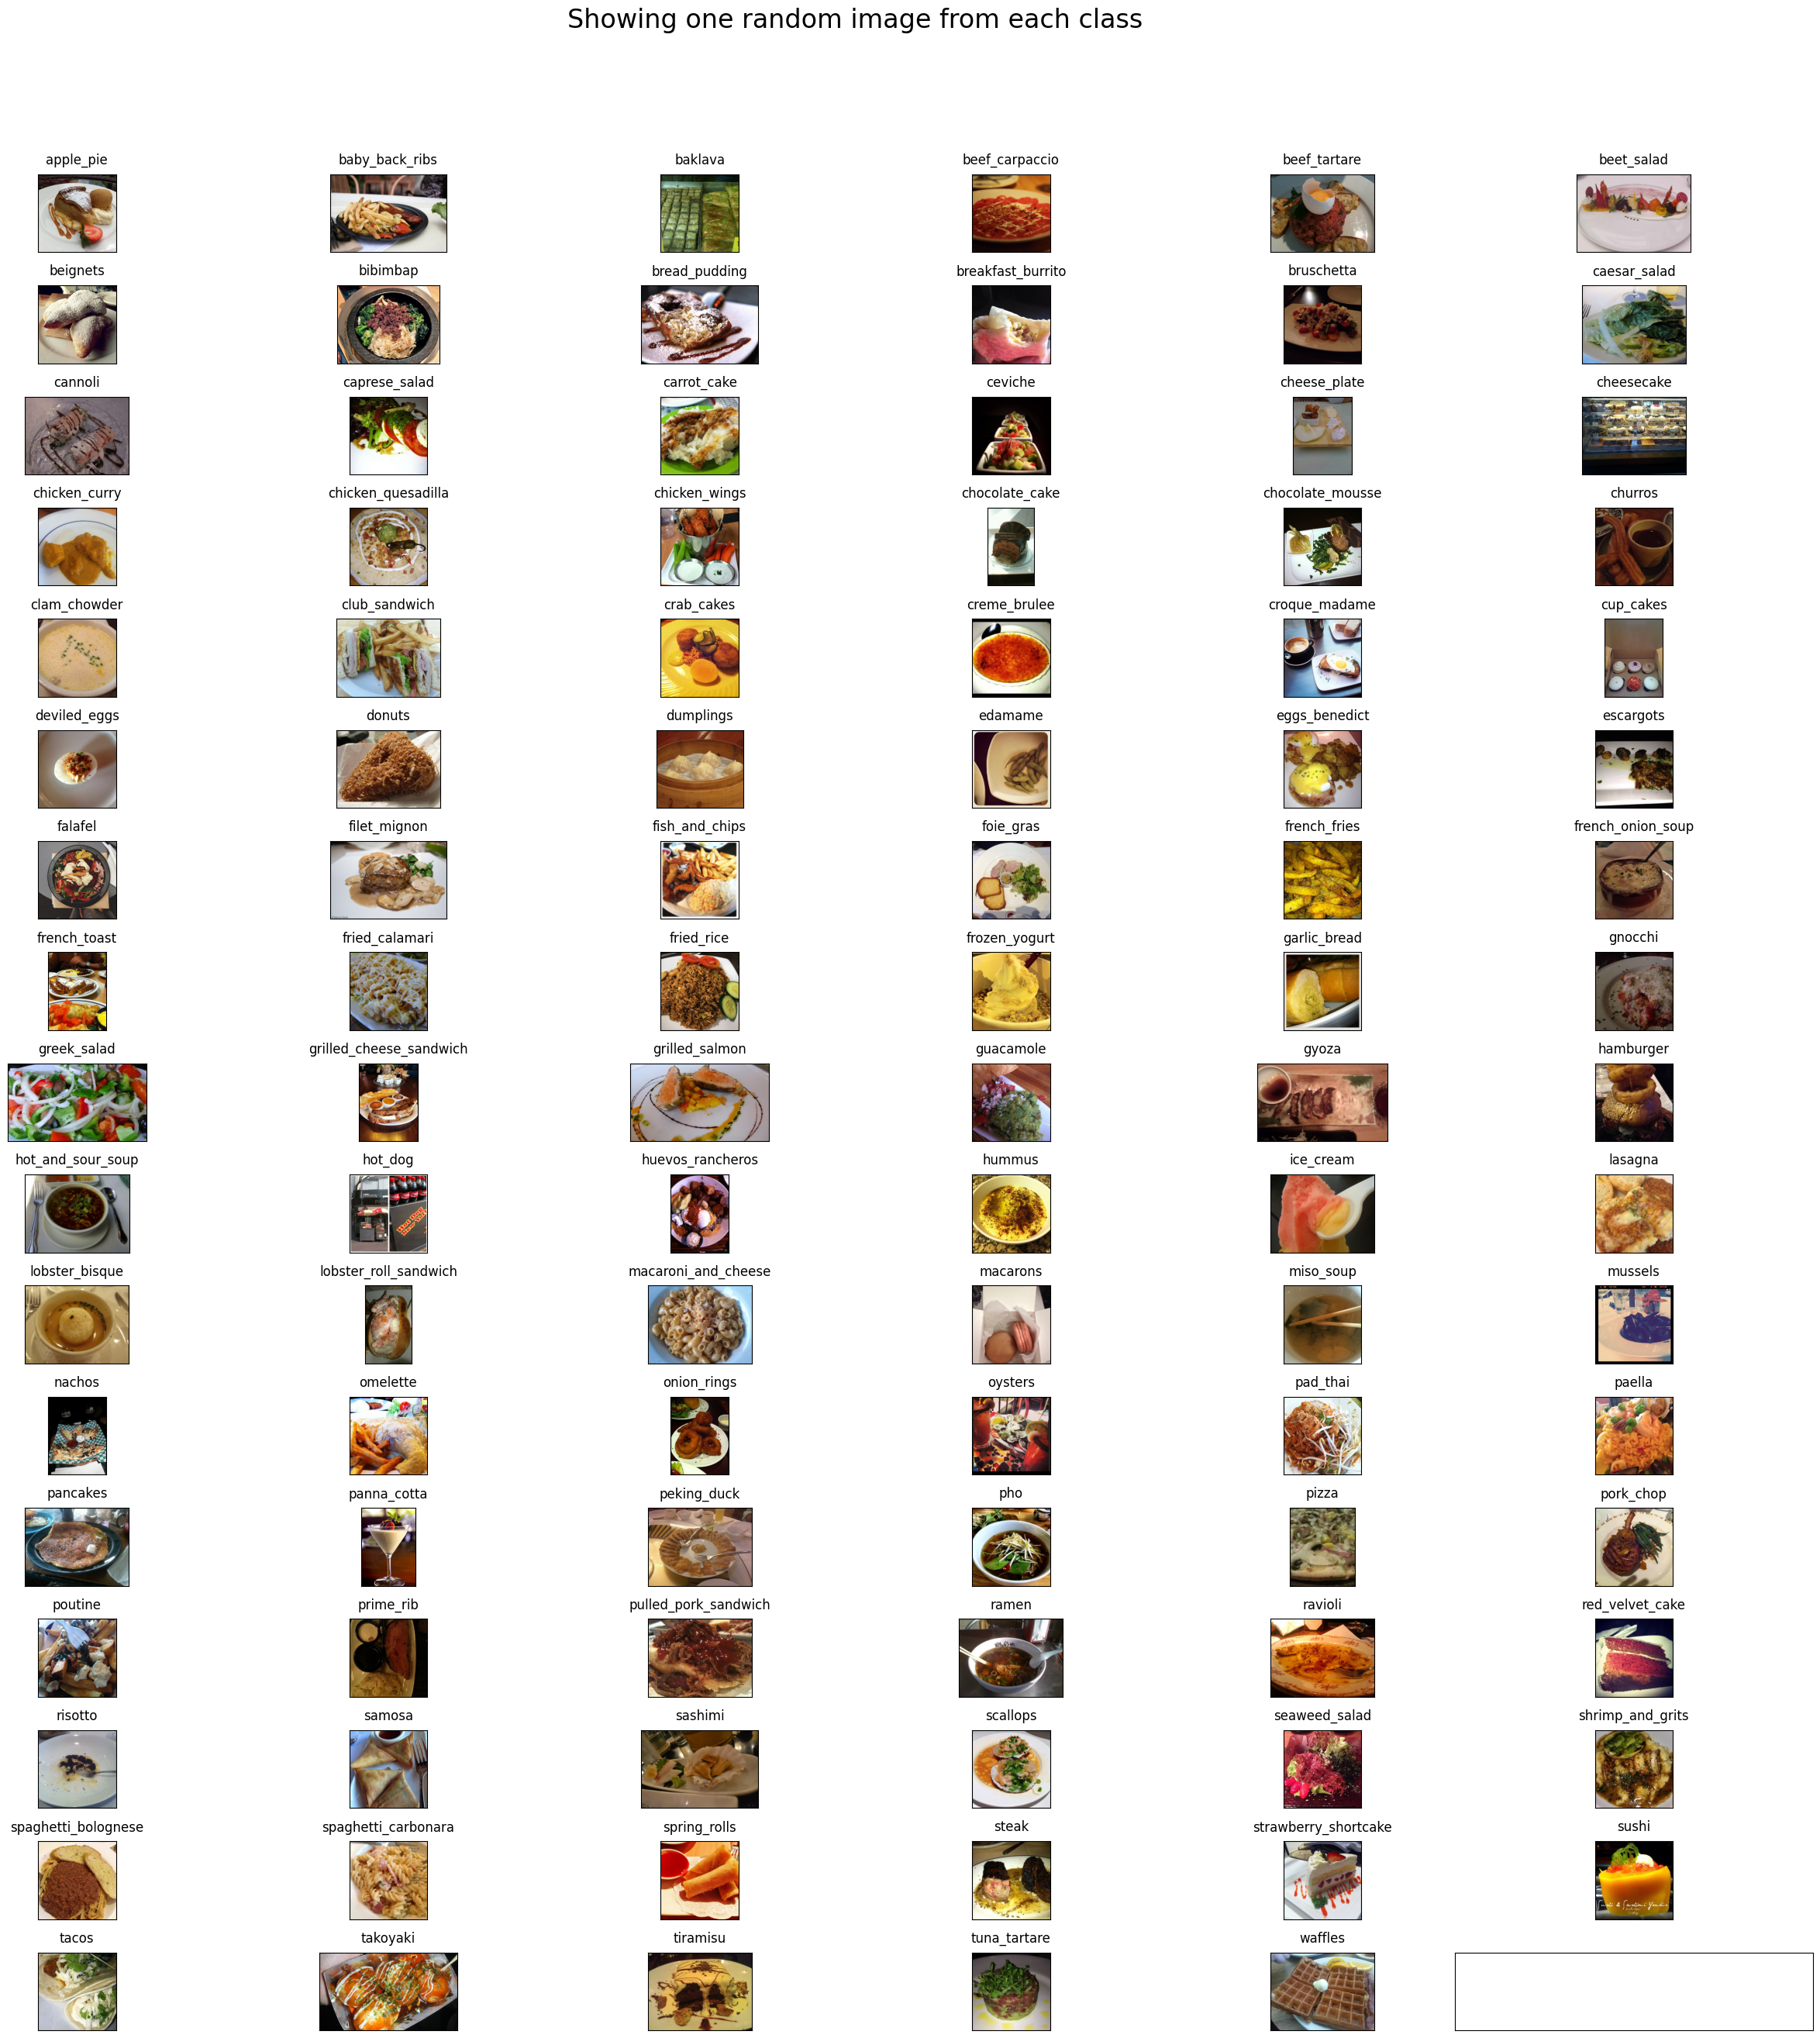

In [16]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101_extracted/food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [17]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [18]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101_extracted/food-101/meta/train.txt', 'food-101_extracted/food-101/images', 'food-101_extracted/food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [19]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101_extracted/food-101/meta/test.txt', 'food-101_extracted/food-101/images', 'food-101_extracted/food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [20]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101_extracted/food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [21]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101_extracted/food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (3)

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [22]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [23]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [24]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = 'food-101_extracted/food-101/train'
dest_train = 'food-101_extracted/food-101/train_mini'
src_test = 'food-101_extracted/food-101/test'
dest_test = 'food-101_extracted/food-101/test_mini'

In [25]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [26]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101_extracted/food-101/train_mini")])
print(train_files)

Total number of samples in train folder
0


In [27]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [28]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101_extracted/food-101/test_mini")])
print(test_files)

Total number of samples in test folder
750


# Fine tune Inception Pretrained model using Food 101 dataset

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [41]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101_extracted/food-101/train'
  validation_data_dir = 'food-101_extracted/food-101/test'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.keras'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.keras'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 101
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Epoch 1/5
 258/4735 ━━━━━━━━━━━━━━━━━━━━ 29:57 402ms/step - accuracy: 0.0084 - loss: 5.2481

# Visualize the accuracy and loss plots

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_acc']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* The plots show that the accuracy of the model increased with epochs and the loss has decreased
* Validation accuracy has been on the higher side than training accuracy for many epochs
* This could be for several reasons:
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* The best model saved has a Top-1 validation accuracy of 93%



# Predicting classes for new images from internet using the best trained model

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()


In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/examples/community/en/multi_class_classification/images/'
images.append(imagepath+'samosa.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)

The model got them all right!

# Fine tune Inceptionv3 model with 11 classes of data

* We trained a model on 3 classes and tested it using new data
* The model was able to predict the classes of all three test images correctly
* Will it be able to perform at the same level of accuracy for more classes?
* FOOD-101 dataset has 101 classes of data
* Even with fine tuning using a pre-trained model, each epoch was taking more than an hour when all 101 classes of data is used(tried this on both Colab and on a Deep Learning VM instance with P100 GPU on GCP)
* But to check how the model performs when more classes are included, I'm using the same model to fine tune and train on 11 randomly chosen classes


In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(11)

In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101_extracted/food-101/train_mini")])
print(train_files)

In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101_extracted/food-101/test_mini")])
print(test_files)

In [ ]:
# Train the model with data from 3 classes
n_classes = 11
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_11 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_11)

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* The plots show that the accuracy of the model increased with epochs and the loss has decreased
* Validation accuracy has been on the higher side than training accuracy for many epochs
* This could be for several reasons:
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* I set number of epochs to just 10, as each epoch's taking around 6mins
* loss is still decreasing, so the model can be trained for some more epochs
* Increase the number of epochs for better accuracy



In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_11class.hdf5',compile = False)

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append(imagepath+'friedrice.jpg')
images.append(imagepath+'hotdog.jpg')
images.append(imagepath+'icecream.jpg')
images.append(imagepath+'pizza.jpg')
predict_class(model_best, images, True)

* The model did well even when the number of classes are increased to 11
* Model training on all 101 classes takes some time
* It was taking more than an hour for one epoch when the full dataset is used for fine tuning

# Summary of the things I tried
* This notebook is the refactored and organised version of all the experiments and training trials I made
* I used this very useful Keras blog - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html for reference
* I spent considerable amount of time in fixing things even before getting to the model training phase
* For example, it took some time to get the image visualization plots aligned withouth any overlap
* It is easier to go through a notebook and understand code someone else has taken hours to finish
* I started with VGG16 pretrained model. It did give good validation accuracy after training for few epochs
* I then tried Inceptionv3. VGG was taking more time for each epoch and since inception was also giving good validation accuracy, I chose Inception over VGG
* For data augmentation, I sticked to the transformations used in the above blog
* I didnt use TTA except rescaling test images
* To avoid Colab connection issues during training, I set number of epochs to 10


# Further Improvements
* Try more augmentation on test images
* Fine tune the model on the entire dataset(for a few epochs atleast)
* Play with hyper parameters, their values and see how it impacts model performance
* There is currently no implementation to handle out of distribution / no class scenario. Can try below methods:
    * Set a threshold for the class with highest score. When model gives prediction score below the threshold for its top prediction, the prediction can be classified as NO-CLASS / UNSEEN
    * Add a new class called **NO-CLASS**, provide data from different classes other than those in the original dataset. This way the model also learns how to classify totally unseen/unrelated data
    * I am yet to try these methods and not sure about the results
* Recently published paper - [Rethinking ImageNet Pretraining](https://arxiv.org/abs/1811.08883 ), claims that training from random initialization instead of using pretrained weights is not only robust but also gives comparable results
* Pre-trained models are surely helpful. They save a lot of time and computation. Yet, that shouldn't be the reason to not try to train a model from scratch


# References
* Deep Learning with Python by Francois Cholett - must read really!
* [Building Powerful Image Classification Models](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [How Convolutional Neural Networks See the World](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
* [Feature Visualization](https://distill.pub/2017/feature-visualization/)